In [42]:
!pip install --quiet scikit-learn torchsummary

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

data_path = 'data'

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
_, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the best model
best_model = CNN()
best_model.load_state_dict(torch.load('best_CNN_model.pth'))
best_model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [21]:
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Convert labels and predictions to numpy arrays
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

In [22]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate and print various metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Test Accuracy: 99.38%
Precision: 0.9951
Recall: 0.9926
F1 Score: 0.9938

Confusion Matrix:
[[392   2]
 [  3 403]]


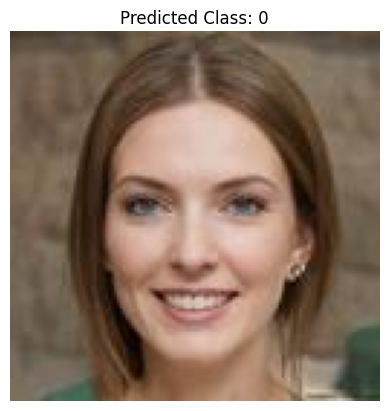

In [47]:
image_path = "data/fake/f1299.jpg"

image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

image = Image.open(image_path).convert("RGB")
input_image = image_transform(image).unsqueeze(0) 

best_model.eval()

with torch.no_grad():
    output = best_model(input_image)
    _, predicted = torch.max(output, 1)

plt.imshow(image)
plt.title(f"Predicted Class: {predicted.item()}")
plt.axis('off')
plt.show()

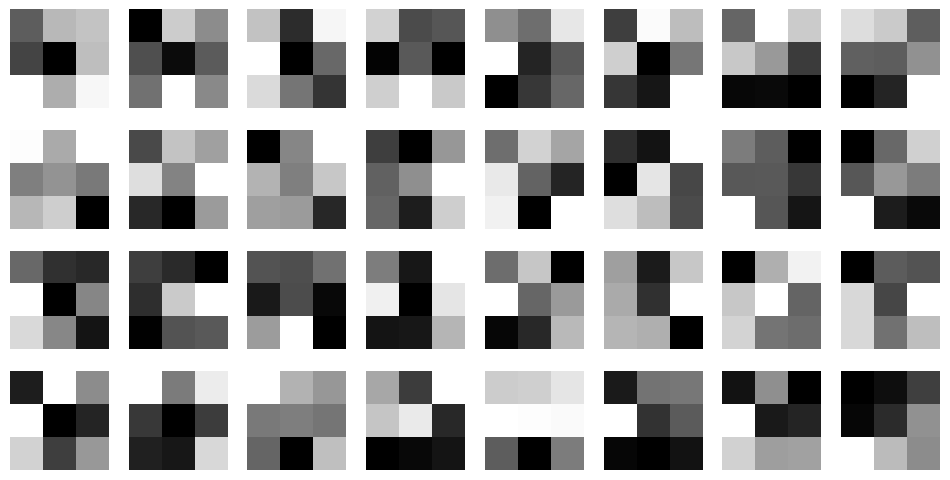

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming conv1 is the first convolutional layer in your model
filters = best_model.conv1.weight.data.cpu().numpy()

# Plot the filters
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i, 0], cmap='gray')
    ax.axis('off')

plt.show()